In [ ]:
# Cosas por hacer
#    - No me da tiempo a sacar las imgs de la segunda solución
#    - Quedan los ejs del final
#    - Falta parte tessim y sirena
#    - Espectro ufs, delchi no coincide con tutorial


In [1]:
import copy
import glob
import matplotlib.colors as colors
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas
import time
import tempfile
import shutil, shlex


from astropy.io import fits
from astropy.visualization import astropy_mpl_style
from datetime import datetime
from funcs import *
from simulation_imports import *
from subprocess import check_call, STDOUT
from xspec import Xset, Plot, AllData, ModelManager, Spectrum, Model, AllModels, Fit

plt.style.use(astropy_mpl_style)


In [2]:
tmpDir = tempfile.mkdtemp()
os.environ["PFILES"] = tmpDir + ":" + os.environ["PFILES"]
os.environ["HEADASNOQUERY"] = ""
os.environ["HEADASPROMPT"] = "/dev/null/"
SIXTE = os.environ["SIXTE"]
xmldir = "{}/share/sixte/instruments/athena-xifu".format(SIXTE)


In [3]:
# Simput file for xifu_point_source.xcm (download needed)

xcm = 'xifu_point_source.xcm'
sim_file = 'xifu_point_source.simput'

RA=239.064583333
Dec=66.3470277776
srcFlux=2e-12

rewrite = True

if rewrite:
    if os.path.exists(sim_file):
        os.remove(sim_file)
    run_comm('simputfile Simput={} RA={} Dec={} srcFlux={} Emin=0.1 Emax=10 XSPECFile={} '.format(sim_file, RA, Dec, srcFlux, xcm) +
             ' clobber=yes', 'Creating simput file for point source')
else:
    print("Simput file ({}) already exists: it will not be overwritten".format(sim_file))


Creating simput file for point source
simputfile Simput=xifu_point_source.simput RA=239.064583333 Dec=66.3470277776 srcFlux=2e-12 Emin=0.1 Emax=10 XSPECFile=xifu_point_source.xcm  clobber=yes


In [4]:
# Running simulation

XMLFile='{}/xifu_baseline.xml'.format(xmldir)
AdvXml='{}/xifu_detector_lpa_75um_AR0.5_pixoffset_mux40_pitch275um.xml'.format(xmldir)
evt_file = 'xifu_point_source_evt.fits'


rewrite = False
if rewrite:
    if os.path.exists(evt_file):
        os.remove(evt_file)
    run_comm('xifupipeline XMLFile={} AdvXml={} RA={} Dec={} '.format(XMLFile, AdvXml, RA, Dec) +
             'EvtFile={} Simput={} Exposure=100000 clobber=yes'.format(evt_file, sim_file), 'Simulating simput file')

else:
    print("Event files already exist: they will not be overwritten".format(evt_file))


Event files already exist: they will not be overwritten


In [5]:
# Create spectrum
spec_file = 'xifu_point_source_spec.pha'
rewrite = True
if rewrite:
    if os.path.exists(spec_file):
        os.remove(spec_file)
    run_comm("makespec EvtFile={} Spectrum={}  EventFilter='GRADING==1' clobber=yes RSPPath={}".format(evt_file, spec_file, xmldir), 'Generating spectrum')
else:
    print('Spec file {} already exists, it will not be overwritten'.format(spec_file))


Generating spectrum
makespec EvtFile=xifu_point_source_evt.fits Spectrum=xifu_point_source_spec.pha  EventFilter='GRADING==1' clobber=yes RSPPath=/home/dgiron/sixtebin/share/sixte/instruments/athena-xifu


In [6]:
Plot.device = '/null'
AllData.clear()
AllModels.clear()
s1 = Spectrum(spec_file)
m0 = Model("phabs*apec")
s1.ignore('**-0.8')
s1.ignore('3.0-**')
Fit.perform()

Plot.device = "/xs"
Plot.xAxis="KeV"
Plot("ufs","delchi")

In [25]:
# 1st solution: Using existing 2D maps


# Simput file for xifu_point_source.xcm (download needed)

xcm = 'xifu_point_source.xcm'
sim_file = 'clusterA2146.simput'
img_file = "A2146_SXB_russel_coord_cal.fits"
param_files = "A2146_kt_russel_coord_cal.fits;A2146_ab_russel_coord_cal.fits"

RA=239.064583333
Dec=66.3470277776
srcFlux=7.995076796356145e-12

rewrite = False

if rewrite:
    if os.path.exists(sim_file):
        os.remove(sim_file)
    run_comm('simputmultispec Simput={} XSPECFile={} ImageFile={} ParamFiles={} ParamNames=2;3 ParamsLogScale=yes;no'.format(sim_file, xcm, img_file, param_files) +
             ' ParamsNumValues=8;8 Emin=0.5 Emax=10.0 RA={} Dec={} srcFlux={} Elow=0.2 Eup=12 Estep=0.00025 clobber=yes'.format(RA, Dec, srcFlux), 'Creating simput file for point source')
else:
    print("Simput file ({}) already exists: it will not be overwritten".format(sim_file))


Simput file (clusterA2146.simput) already exists: it will not be overwritten


In [26]:
# Running simulation

XMLFile='{}/xifu_baseline.xml'.format(xmldir)
AdvXml='{}/xifu_detector_lpa_75um_AR0.5_pixoffset_mux40_pitch275um.xml'.format(xmldir)
evt_file = '2d_maps_evt.fits'


rewrite = False
if rewrite:
    if os.path.exists(evt_file):
        os.remove(evt_file)
    run_comm('xifupipeline XMLFile={} AdvXml={} RA={} Dec={} '.format(XMLFile, AdvXml, RA, Dec) +
             'EvtFile={} Simput={} Exposure=100000 clobber=yes'.format(evt_file, sim_file), 'Simulating simput file')

else:
    print("Event files already exist: they will not be overwritten".format(evt_file))


Event files already exist: they will not be overwritten


Event file 2d_maps_img.fits already exists, it wont be overwritten
Opening image
xdg-open imgs/imgev_xifu.png


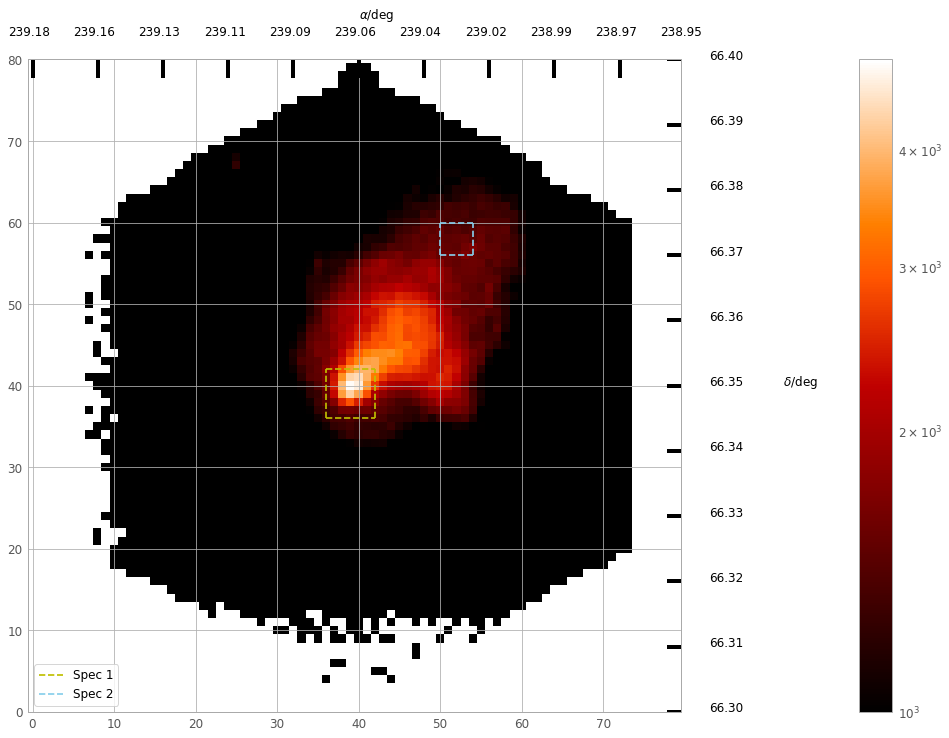

In [61]:
img_file = '2d_maps_img.fits'

rewrite = False
if rewrite:
    run_comm('imgev EvtFile={} Image={} CoordinateSystem=0 Projection=TAN CUNIT1=deg CUNIT2=deg NAXIS1=80 NAXIS2=80'.format(evt_file, img_file) +
             ' CRVAL1={} CRVAL2={} CDELT1=-0.0011888874248538006 CDELT2=0.0011888874248538006 CRPIX1=40.5 CRPIX2=40.5 clobber=yes'.format(RA, Dec, 'Creating eRosita image'))
else:
    print('Event file {} already exists, it wont be overwritten'.format(img_file))




image_data = fits.getdata(img_file, ext=0)
image_data2 = image_data[150:250, 150:250]

fig, _axs = plt.subplots(nrows=1, ncols=1, figsize=(16*2,6*2))
axs = _axs
axs = [axs]


sq_dwl = np.array((239.18, 66.30))
sq_upr = np.array((238.946, 66.40))

draw_second_axis(fig, axs, sq_downleft=sq_dwl, sq_upright=sq_upr, ln=80, mov_ra=3, mov_dec=0, lon_lines=2, num_lines=10,
                mov_x_text=[0, 5], mov_y_text=[12, 0], xlabel=r'$\alpha$/deg', ylabel=r'$\delta$/deg', num_axis=0, dist_txt=3, zero_between=False, display_format='.2f')

sq1, sq2 = get_zoom_coord(sq_dwl, sq_upr, 80, [36, 42], [36, 42])

sq1_out, sq2_out = get_zoom_coord(sq_dwl, sq_upr, 80, [50, 54], [56, 60])

axs[0].plot([36, 36], [36, 42], 'y--')
axs[0].plot([42, 42], [36, 42], 'y--')
axs[0].plot([36, 42], [36, 36], 'y--')
axs[0].plot([36, 42], [42, 42], 'y--', label='Spec 1')

axs[0].plot([50, 50], [56, 60], '--' ,color='skyblue')
axs[0].plot([54, 54], [56, 60], '--', color='skyblue')
axs[0].plot([50, 54], [56, 56], '--', color='skyblue')
axs[0].plot([50, 54], [60, 60], '--', color='skyblue', label='Spec 2')
axs[0].legend()



axs[0].set_ylim(0, len(image_data))


cmap = plt.cm.gist_heat
im = axs[0].imshow(image_data, cmap=cmap, norm=colors.LogNorm(vmin=1000, vmax=5000))
fig.colorbar(im,ax=axs[0], pad=0.1)

img_subplot(fig, axs[0], 1.5, 1.2, 'imgs/imgev_xifu.png', True)

In [60]:
# Create spectrum center
spec_file = 'xifu_center_spec.pha'
rewrite = True
if rewrite:
    if os.path.exists(spec_file):
        os.remove(spec_file)
    run_comm("makespec EvtFile={} Spectrum={} RSPPath={} EventFilter='(RA<{} || RA>{}) && Dec<{} && Dec>{}'".format(evt_file, spec_file, xmldir,
                                                                                                                   sq1[0], sq2[0], sq2[1], sq1[1]), 'Generating spectrum')
else:
    print('Spec file {} already exists, it will not be overwritten'.format(spec_file))


Plot.device = '/null'
AllData.clear()
AllModels.clear()

Plot.device = "/xs"
Plot.xAxis="KeV"

AllData.clear()
s1 = Spectrum(spec_file)
s1.ignore("**-0.5")
s1.ignore("7.0-**")
#s1.ignore("bad")
Plot("data")

Generating spectrum
makespec EvtFile=2d_maps_evt.fits Spectrum=xifu_center_spec.pha RSPPath=/home/dgiron/sixtebin/share/sixte/instruments/athena-xifu EventFilter='(RA<239.0747 || RA>239.05715) && Dec<66.3525 && Dec>66.345'


In [58]:
# Create spectrum outside
spec_file = 'xifu_outside_spec.pha'
rewrite = True
if rewrite:
    if os.path.exists(spec_file):
        os.remove(spec_file)
    run_comm("makespec EvtFile={} Spectrum={} RSPPath={} EventFilter='(RA<{} || RA>{}) && Dec<{} && Dec>{}'".format(evt_file, spec_file, xmldir,
                                                                                                                   sq1_out[0], sq2_out[0], sq2_out[1], sq1_out[1]),
             'Generating spectrum')
else:
    print('Spec file {} already exists, it will not be overwritten'.format(spec_file))


Plot.device = '/null'
AllData.clear()
AllModels.clear()

Plot.device = "/xs"
Plot.xAxis="KeV"

AllData.clear()
s1 = Spectrum(spec_file)
s1.ignore("**-0.5")
s1.ignore("7.0-**")
#s1.ignore("bad")
Plot("data")

Generating spectrum
makespec EvtFile=2d_maps_evt.fits Spectrum=xifu_outside_spec.pha RSPPath=/home/dgiron/sixtebin/share/sixte/instruments/athena-xifu EventFilter='(RA<239.03375 || RA>239.02205) && Dec<66.375 && Dec>66.37'


In [16]:
# 2nd solution: Using galaxy cluster simulations

xcm = 'wabs_vapec_cosmo.xcm'
sim_file = 'xifu_3D.simput'
param_files = "xifu_3D_grid.fits"

rewrite = False

if rewrite:
    if os.path.exists(sim_file):
        os.remove(sim_file)
    run_comm('simputmulticell ParamFile={} ParamInputNames="T;FE_ABUND" ParamNames="2;14" InputType=TABLE XSPECFile={}'.format(param_files, xcm) +
             ' ParamsLogScale="no;no" ParamsNumValues="100;100" Estep=0.00025 Emin=0.2 Emax=12.0 Elow=0.2 Eup=12 clobber=yes' +
             '  Simput={}'.format(sim_file), 'Creating simput file for point source')
else:
    print("Simput file ({}) already exists: it will not be overwritten".format(sim_file))


Simput file (xifu_3D.simput) already exists: it will not be overwritten


In [18]:
# Running simulation
RA = 0
Dec = 0


XMLFile='{}/xifu_baseline.xml'.format(xmldir)
AdvXml='{}/xifu_detector_lpa_75um_AR0.5_pixoffset_mux40_pitch275um.xml'.format(xmldir)
evt_file = 'gal_clusters_sim_evt.fits'


rewrite = True
if rewrite:
    if os.path.exists(evt_file):
        os.remove(evt_file)
    run_comm('xifupipeline XMLFile={} AdvXml={} RA={} Dec={} '.format(XMLFile, AdvXml, RA, Dec) +
             'EvtFile={} Simput={} Exposure=1000 clobber=yes'.format(evt_file, sim_file), 'Simulating simput file')

else:
    print("Event files already exist: they will not be overwritten".format(evt_file))


Simulating simput file
xifupipeline XMLFile=/home/dgiron/sixtebin/share/sixte/instruments/athena-xifu/xifu_baseline.xml AdvXml=/home/dgiron/sixtebin/share/sixte/instruments/athena-xifu/xifu_detector_lpa_75um_AR0.5_pixoffset_mux40_pitch275um.xml RA=239.064583333 Dec=66.3470277776 EvtFile=gal_clusters_sim_evt.fits Simput=xifu_3D.simput Exposure=1000 clobber=yes



imgev EvtFile=gal_clusters_sim_evt.fits Image=gal_clusters_sim_img.fits CoordinateSystem=0 Projection=TAN CUNIT1=deg CUNIT2=deg NAXIS1=80 NAXIS2=80 CRVAL1=239.064583333 CRVAL2=66.3470277776 CDELT1=-0.0011888874248538006 CDELT2=0.0011888874248538006 CRPIX1=40.5 CRPIX2=40.5 clobber=yes


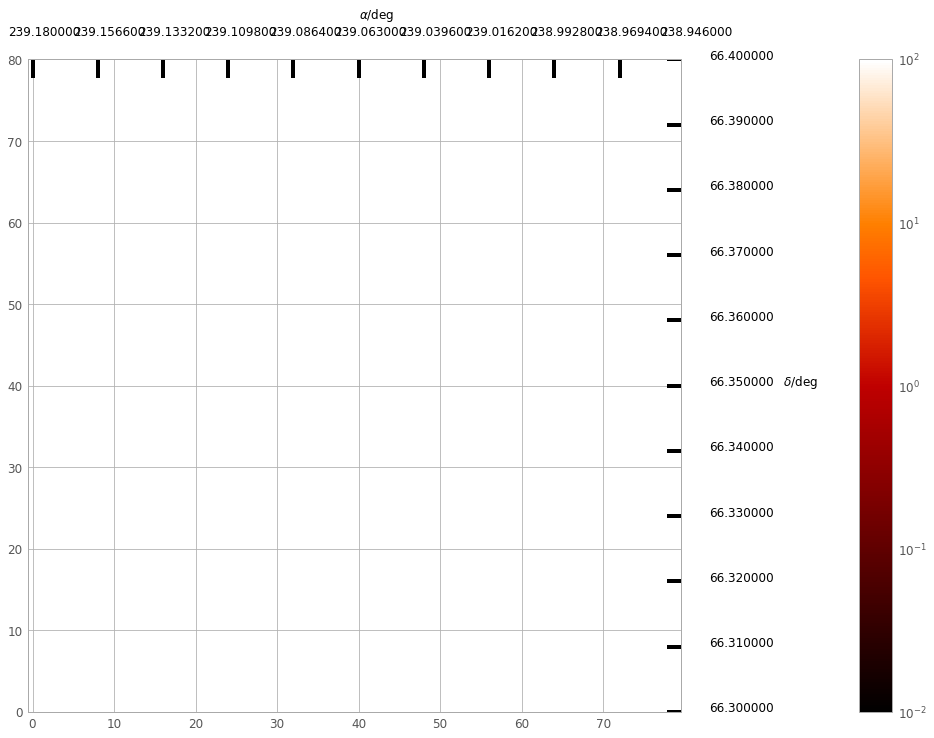

In [19]:
img_file = 'gal_clusters_sim_img.fits'

rewrite = True
if rewrite:
    run_comm('imgev EvtFile={} Image={} CoordinateSystem=0 Projection=TAN CUNIT1=deg CUNIT2=deg NAXIS1=80 NAXIS2=80'.format(evt_file, img_file) +
             ' CRVAL1={} CRVAL2={} CDELT1=-0.0011888874248538006 CDELT2=0.0011888874248538006 CRPIX1=40.5 CRPIX2=40.5 clobber=yes'.format(RA, Dec, 'Creating eRosita image'))
else:
    print('Event file {} already exists, it wont be overwritten'.format(img_file))


image_data = fits.getdata(img_file, ext=0)

fig, _axs = plt.subplots(nrows=1, ncols=1, figsize=(16*2,6*2))
axs = _axs
axs = [axs]


sq_dwl = np.array((239.18, 66.30))
sq_upr = np.array((238.946, 66.40))

draw_second_axis(fig, axs, sq_downleft=sq_dwl, sq_upright=sq_upr, ln=80, mov_ra=3, mov_dec=0, lon_lines=2, num_lines=10,
                mov_x_text=[0, 5], mov_y_text=[12, 0], xlabel=r'$\alpha$/deg', ylabel=r'$\delta$/deg', num_axis=0, dist_txt=3, zero_between=False, display_format='2f')

axs[0].set_ylim(0, len(image_data))


cmap = plt.cm.gist_heat
im = axs[0].imshow(image_data, cmap=cmap, norm=colors.LogNorm(vmin=0.01, vmax=100))
fig.colorbar(im,ax=axs[0], pad=0.1)



In [70]:
# Create spectrum
spec_file = 'gal_clusters_sim_spec.pha'
rewrite = True
if rewrite:
    if os.path.exists(spec_file):
        os.remove(spec_file)
    run_comm("makespec EvtFile={} Spectrum={}  EventFilter='GRADING==1 && PIXID==1953' clobber=yes RSPPath={}".format(evt_file, spec_file, xmldir), 'Generating spectrum')
else:
    print('Spec file {} already exists, it will not be overwritten'.format(spec_file))


Generating spectrum
makespec EvtFile=gal_clusters_sim_evt.fits Spectrum=gal_clusters_sim_spec.pha  EventFilter='GRADING==1 && PIXID==1953' clobber=yes RSPPath=/home/dgiron/sixtebin/share/sixte/instruments/athena-xifu


In [66]:
Plot.device = '/null'
AllData.clear()
AllModels.clear()

Plot.device = "/xs"
Plot.xAxis="KeV"

# rebin spectral data

binspec = "gal_clusters_sim_rebin.pha"

rewrite = True
if rewrite:
    if os.path.exists(binspec):
            os.remove(binspec)
    comm = ("grppha infile={} outfile={} clobber=yes".format(spec_file, binspec))    
    run_comm(comm, "Rebinning spectrum")
else:
    print("Rebin file ({}) already exists: it will not be overwritten".format(binspec))

AllData.clear()
s1 = Spectrum(binspec)
s1.ignore("**-0.5")
s1.ignore("7.0-**")
#s1.ignore("bad")
Plot("data")

Rebinning spectrum
grppha infile=gal_clusters_sim_spec.pha outfile=gal_clusters_sim_rebin.pha clobber=yes


### Running simulations with tessine

In [76]:
# Example of a photon impact list with just one photon

PixImpList = "piximpact_2keV.fits"

rewrite = True
if rewrite:
    if os.path.exists(PixImpList):
            os.remove(PixImpList)
    run_comm("tesgenimpacts mode=const tstart=0 tstop=0.3 dtau=200 EConst=2".format(PixImpList), 'Creating impact list')    
else:
    print("Impact list file ({}) already exists: it will not be overwritten".format(PixImpList))



Creating impact list
tesgenimpacts mode=const tstart=0 tstop=0.3 dtau=200 EConst=2


In [77]:
Streamfile='tessim_output_2keV.fits'

rewrite = True
if rewrite:
    if os.path.exists(Streamfile):
            os.remove(Streamfile)
    run_comm("tessim tstart=0 tstop=0.4 PixType='file:LPA2.5a_tessim.fits' PixImpList={} Streamfile={}".format(PixImpList, Streamfile) +
             ' PixID=1 triggertype="diff:3:100:" triggersize=9000', 'Creating impact list')    
else:
    print("Event file ({}) already exists: it will not be overwritten".format(Streamfile))


Creating impact list
tessim tstart=0 tstop=0.4 PixType='file:LPA2.5a_tessim.fits' PixImpList=piximpact_2keV.fits Streamfile=tessim_output_2keV.fits PixID=1 triggertype="diff:3:100:" triggersize=9000
Command '['tessim', 'tstart=0', 'tstop=0.4', 'PixType=file:LPA2.5a_tessim.fits', 'PixImpList=piximpact_2keV.fits', 'Streamfile=tessim_output_2keV.fits', 'PixID=1', 'triggertype=diff:3:100:', 'triggersize=9000']' died with <Signals.SIGABRT: 6>.


CalledProcessError: Command '['tessim', 'tstart=0', 'tstop=0.4', 'PixType=file:LPA2.5a_tessim.fits', 'PixImpList=piximpact_2keV.fits', 'Streamfile=tessim_output_2keV.fits', 'PixID=1', 'triggertype=diff:3:100:', 'triggersize=9000']' died with <Signals.SIGABRT: 6>.